In [1]:
import re
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
print(device)

cuda:0


In [3]:
with open('data/data.txt', 'r') as f:
    text = f.read()

In [4]:
chars = tuple(set(text))
int2char = dict(enumerate(chars))
char2int = {ch: ii for ii, ch in int2char.items()}

encoded = np.array([char2int[ch] for ch in text])

In [5]:
def one_hot_encoder(arr, n_labels):
    one_hot = np.zeros((np.multiply(*arr.shape), n_labels), dtype=np.float32)
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    one_hot = one_hot.reshape((*arr.shape, n_labels))
    
    return one_hot

In [6]:
class RNN(nn.Module):  
    def __init__(self, tokens, hidden_size, n_layers, dropout_prob):
        super().__init__()
        self.dropout_prob = dropout_prob
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        
        self.chars = tokens
        self.int2char = dict(enumerate(self.chars))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}
        
        self.lstm = nn.LSTM(len(self.chars), 
                            self.hidden_size, 
                            n_layers, 
                            dropout=dropout_prob,
                            bidirectional=False,
                            batch_first=True
                           )
        
        self.dropout = nn.Dropout(dropout_prob)
        self.lin = nn.Linear(self.hidden_size, len(self.chars))
        
    def forward(self, x, hidden):
        r_output, hidden = self.lstm(x, hidden)
        out = self.dropout(r_output)
        out = out.contiguous().view(-1, self.hidden_size)
        out = self.lin(out)
        return out, hidden
        

    def init_hidden(self, batch_size=1, device=device):
        return (torch.zeros(self.n_layers, batch_size, self.hidden_size, device=device), 
                torch.zeros(self.n_layers, batch_size, self.hidden_size, device=device))

In [7]:
def get_batches(arr, batch_size, seq_length):
    batch_size_total = batch_size * seq_length
    n_batches = len(arr)//batch_size_total
    arr = arr[:n_batches * batch_size_total]
    arr = arr.reshape((batch_size, -1))
    
    for n in range(0, arr.shape[1], seq_length):
        x = arr[:, n:n+seq_length]
        y = np.zeros_like(x)
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n+seq_length]
        except IndexError:
            "Wrong index"
        yield x, y

In [19]:
def train(model, data, epochs, batch_size, seq_length, lr, criterion, optimizer, val_frac, print_every):
    train_loss = []
    validation_loss = []
    epoch_viz = []
    
    val_idx = int(len(data) * (1 - val_frac))
    data, val_data = data[:val_idx], data[val_idx:]

    counter = 0
    n_chars = len(model.chars)
    for epoch in range(epochs):
        hidden = model.init_hidden(batch_size)      
        for x, y in get_batches(data, batch_size, seq_length):
            counter += 1

            x = one_hot_encoder(x, n_chars)
            
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
            inputs, targets = inputs.to(device), targets.to(device)
            hidden = tuple([each.data for each in hidden])
            
            model.zero_grad()
            
            output, hidden = model(inputs, hidden)
                    
            loss = criterion(output, targets.view(batch_size * seq_length).long())
            loss.backward()

            optimizer.step()
            
            # validation
            if counter % print_every == 0:
                val_hidden = model.init_hidden(batch_size)
                val_losses = []
                model.eval()
                for x, y in get_batches(val_data, batch_size, seq_length):
                    x = one_hot_encoder(x, n_chars)
                    x, y = torch.from_numpy(x), torch.from_numpy(y)
                    val_hidden = tuple([each.data for each in val_hidden])
                    
                    inputs, targets = x, y
                    inputs, targets = inputs.to(device), targets.to(device)

                    output, val_hidden = model(inputs, val_hidden)
                    val_loss = criterion(output, targets.view(batch_size * seq_length).long())
                
                    val_losses.append(val_loss.item())
                
                model.train()
                
                print("Epoch: {}/{}...".format(epoch + 1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.4f}...".format(loss.item()),
                      "Val Loss: {:.4f}".format(np.mean(val_losses)))
                
                train_loss.append(loss.item())
                validation_loss.append(np.mean(val_losses))
                epoch_viz.append(epoch+1)
    return train_loss, validation_loss, epoch_viz

In [22]:
hidden_size = 768
n_layers = 3
dropout_prob = 0.5

model = RNN(tokens=chars, hidden_size=hidden_size, n_layers=n_layers, dropout_prob=dropout_prob).to(device)
model.train()

RNN(
  (lstm): LSTM(186, 768, num_layers=3, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5)
  (lin): Linear(in_features=768, out_features=186, bias=True)
)

In [23]:
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr, amsgrad=True)
criterion = nn.CrossEntropyLoss()

In [24]:
# train the model
batch_size = 64
seq_length = 150
n_epochs = 40
print_every = 100
val_frac = 0.1
model.train()

RNN(
  (lstm): LSTM(186, 768, num_layers=3, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5)
  (lin): Linear(in_features=768, out_features=186, bias=True)
)

In [25]:
skip_training = False

In [26]:
if skip_training == False:
    train_loss, validation_loss, epoch_viz = train(model=model, 
                                                  data=encoded, 
                                                  epochs=n_epochs, 
                                                  batch_size=batch_size, 
                                                  seq_length=seq_length, 
                                                  lr=lr, 
                                                  criterion=criterion, 
                                                  optimizer=optimizer, 
                                                  print_every=print_every, 
                                                  val_frac=val_frac,
                                                 )

Epoch: 1/40... Step: 100... Loss: 3.1614... Val Loss: 3.2643
Epoch: 1/40... Step: 200... Loss: 2.9635... Val Loss: 3.0037
Epoch: 2/40... Step: 300... Loss: 2.7317... Val Loss: 2.8307
Epoch: 2/40... Step: 400... Loss: 2.5570... Val Loss: 2.6984
Epoch: 3/40... Step: 500... Loss: 2.5022... Val Loss: 2.5130
Epoch: 3/40... Step: 600... Loss: 2.3395... Val Loss: 2.4913
Epoch: 3/40... Step: 700... Loss: 2.2301... Val Loss: 2.4104
Epoch: 4/40... Step: 800... Loss: 2.2234... Val Loss: 2.2718
Epoch: 4/40... Step: 900... Loss: 2.0823... Val Loss: 2.2065
Epoch: 5/40... Step: 1000... Loss: 2.0578... Val Loss: 2.0684
Epoch: 5/40... Step: 1100... Loss: 1.9721... Val Loss: 2.0513
Epoch: 5/40... Step: 1200... Loss: 1.9415... Val Loss: 2.0116
Epoch: 6/40... Step: 1300... Loss: 1.8968... Val Loss: 1.9481
Epoch: 6/40... Step: 1400... Loss: 1.8657... Val Loss: 1.9428
Epoch: 7/40... Step: 1500... Loss: 1.8218... Val Loss: 1.8793
Epoch: 7/40... Step: 1600... Loss: 1.8342... Val Loss: 1.8858
Epoch: 8/40... St

In [27]:
if skip_training == False:
    torch.save(model, 'model')
else:
    model = torch.load('model')
    model.eval()

/u/15/porjazd1/unix/.local/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


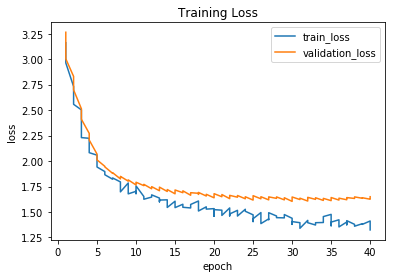

In [28]:
if skip_training == False:
    plt.plot(epoch_viz, train_loss)
    plt.plot(epoch_viz, validation_loss)
    plt.legend(['train_loss', 'validation_loss'])
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Training Loss')
    plt.savefig('images/loss.png', dpi=400)
    plt.show()

In [29]:
# Defining a method to generate the next character
def predict(model, char, hidden=None, top_k=None):
        ''' Given a character, predict the next character.
            Returns the predicted character and the hidden state.
        '''
        
        # tensor inputs
        x = np.array([[model.char2int[char]]])
        x = one_hot_encoder(x, len(model.chars))
        
        inputs = torch.from_numpy(x)
        inputs = inputs.to(device)
        
        hidden = tuple([each.data for each in hidden])
        output, hidden = model(inputs, hidden)

        p = F.softmax(output, dim=1).data
        p = p.cpu()
        
        if top_k is None:
            top_ch = np.arange(len(model.chars))
        else:
            p, top_ch = p.topk(top_k)
            top_ch = top_ch.numpy().squeeze()
        
        p = p.numpy().squeeze()
        char = np.random.choice(top_ch, p=p / p.sum())
        return model.int2char[char], hidden

In [30]:
def sample(model, size, prime, top_k=None):
    model.to(device)   
    model.eval()
    chars = [ch for ch in prime]
    hidden = model.init_hidden(1)
    for ch in prime:
        char, hidden = predict(model, ch, hidden, top_k=top_k)

    chars.append(char)

    for ii in range(size):
        char, hidden = predict(model, chars[-1], hidden, top_k=top_k)
        chars.append(char)
    
    text = ''.join(chars)
    return text

In [38]:
text = sample(model, 1000, prime=' ', top_k=5)

In [39]:
# remove punctuation
def remove_punctuation(text):
    words_clean = []
    for word in text.split():
        words_clean.append(re.sub(r'[^\w\s]', '', word))
    return words_clean

In [40]:
clean_text = remove_punctuation(text)

In [41]:
def evaluate(clean_text):
    correct_words = 0
    incorrect_words = 0
    
    with open('data/unique_words.txt', 'r') as f:
        vocab = f.read().splitlines()
        
    for word in clean_text:
        if word in vocab:
            correct_words += 1
        else:
            incorrect_words += 1
    
    accuracy = correct_words / (correct_words + incorrect_words)
    return accuracy, correct_words, incorrect_words

In [42]:
accuracy, correct_words, incorrect_words = evaluate(clean_text)

In [43]:
print('Number of correct words is: {}, number of incorrect words is {}, accuracy is: {}'.format(correct_words, incorrect_words, accuracy))

Number of correct words is: 187, number of incorrect words is 6, accuracy is: 0.9689119170984456


In [44]:
print(text)

 полетај го просторот. 
И те зема со мене на тебе,
каде е мојата средба. 
Стоевме за тебе не сме по него
и носат секилности, 
се невини, некои да ми се споредуваат.

Како проклети сончеви погледи непривезени
оваа коска на нив да се однесеме,
а јас не се сеќавам на себе

Толку пријатно небо,
по небото светлина,
пред свилена светлина,
вечна наша верби и треперливи изгрејсонца
сега веќе не е важно
кога сум само толку далечно
и да се потплетам во темнината.

Не ми спие, туку сум и не знам
и ти ми продолжи во ноќта.

Празнина со насмевка во мојата средба
и столб одмината
и пак да ги скриеш.
Ти ме сакаше,?
со твојот сјај негов
и секоја вечер пееше
со некоја друга.
Имам сила да те повредам
исчезнуваш и сега не се раѓам. 
Немам приказна.
Но не плачи.
Но немам последен пат,
не знам како е само,
ти, ти се, таа е твојот свет.
Тебе во себе нема небо,
сите сме имање, сонце да не продолжиме
и не е плач,
но сега сум јас со себе.

На мисла ни солзи им ги виде,
низ своите прсти во некако меѓу мене
и со